# QuaSaR: Identifying EEW Rings - Waveform Analysis

[Quake Safe Rings](./1a_stations_faultlnes_plot.ipynb) - in our efforts to understand the station waveform data - we are using GeoNet provided [FDSN IRIS SeedLink API](http://ds.iris.edu/ds/nodes/dmc/services/seedlink/). The intent is to:
1. Make use of the SeedLink to get station-wise 3-component (N, E, Z) accelerometer data for a given time window and apply selected picking algorithms to the waverform traces to detect earthquakes
  1. Using the first 3s of the Verticle Displacement Amplitude (___Pd___) is the most common method for calculating the magnitude by applying the autoregression function. This value appears to be valid at least in the magnitude range from 3.0 to 6.5
1. Convert the time-series to tensors to be able to apply linear algebra and calculus on the datasets
1. Formulate station rings based on the class of tensors they belong to (e.g. accelerometers)

In [1]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('default')     #switch between 'default' and 'ignore'

### Class for picking earthquakes

* _get_filtered_trace() returns 

In [2]:
class picks():
    ''' Initialize the picking algorithm model '''
    def __init__(self, model_name = 'lta-sta'):
        super().__init__()
        
        self.model_name = model_name
        all_transforms = []
        
        if self.model_name == None:
            print('Unspecified model_name')
            ''' lta-sta '''
        elif self.model_name == 'lta-sta':
            all_transforms.append('decimate',factor=4, no_filter=False, strict_length=False)
            all_transforms.append('lowpass',freq=0.4*item_tr.stats.sampling_rate / 4.0)
            ''' p-wave '''
        elif self.model_name == 'p-wave':
            all_transforms.append('decimate',factor=4, no_filter=False, strict_length=False)
            all_transforms.append('lowpass',freq=0.4*item_tr.stats.sampling_rate / 4.0)
        else:
            print('Incorrect model name')
        return all_transforms

    def get_bandpass_filtered_trace(self,trance):
        return bandpass_filtered_trace
    def get_fitltered_trace(self,trace, filter: 'bandpass'):
        for idx_tr, item_tr in enumerate(trace):
            tr_new = item_tr.copy()
            tr_new.decimate(factor=4, no_filter=False, strict_length=False)
            tr_filt = item_tr.copy()
            tr_filt.filter('lowpass', freq=0.4*item_tr.stats.sampling_rate / 4.0)


        return filtered_trace
    def get_station_trace(self,station_code = 'KIKS',startdt = None, enddt = None):
        pass

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Get stations
Reuses the class defined in 1c

In [1]:
import sys
sys.path.insert(1, '../lib')

import stations
#import faults

''' TODO send time window '''
cls_st = stations.station_data()
__client = cls_st.get_client()
#lst_val_st, lst_inval_st = cls_st.get_stations(cls_st.get_client())
lst_val_st, lst_inval_st = cls_st.get_stations(__client)
print(f'Number of valid stations: {len(lst_val_st)}')

Retrieving active stations with a 
start-time: 2021-02-15T09:43:55.098433Z 
 & end-time: 2021-02-22T09:43:55.098461Z
FDSN Webservice Client (base url: http://service.geonet.org.nz)
Available Services: 'dataselect' (v1.1), 'event' (v1.1), 'station' (v1.1), 'available_event_catalogs', 'available_event_contributors'

Use e.g. client.help('dataselect') for the
parameter description of the individual services
or client.help() for parameter description of
all webservices.


/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


Number of valid stations: 450


### Method to get traces

1. Get the station fault clusters from 1c to prepare the set of groups of station clusters. Each group must contain, at least, 4 stations. Since these groups are formed such that they are in close proximity to a fault line.     
1. For each of the station groups, get the waveforms (i.e. traces) from FDSN for each station for a common window; typically, a 10 minute sliding window.
1. Cleanup the traces with a bandpass filter or any other desirse filtered to each trace before calculating the source parameters, it is necessary to eliminate low-frequency noise below 0.5 Hz in a 1s time-series cannot be evaluated, and since low frequencies may have large spectral amplitudes, high-pass filtering with a cut-off frequency of 0.5 Hz or above is required. The high-frequency noise, above 25 Hz, almost always has spectral amplitudes several orders of magnitude lower than the peak spectral amplitude. As, in addition, the rise time of the first acceleration peak is only marginally contaminated, application of a low- pass filter appears to be unnecessary. 
   1. [Remove respons to prevent overamplification](https://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.remove_response.html) while convolving the inverted instrument spectrum
1. Run the cleaned traces through a selected ground-motion earthquake detection and characterization method (subsequently finite fault, point source) to pick earthquakes -- either based on an energy method, autoregressive method, or Artificial Neural Network (ANN) method
   1. ___PGA___ ([Peak Ground Acceleration](https://nptel.ac.in/content/storage2/courses/105101004/downloads/02%20Chapter.pdf)) is the maximum acceleration occured during an earthquake at a location
   1. ___PGV___ ([Peak Ground Velocity](https://nptel.ac.in/content/storage2/courses/105101004/downloads/02%20Chapter.pdf)) is the maximum is the largest absolute value of velocity time history. Accurate  estimation  of  these  parameters  is difficult  as  the  errors  in  signal processing  and  numerical  integration  greatly  affect  the  estimation  of  amplitude  of displacement time history. 
   1. ___Pd___ ([Peak Displacement](https://nptel.ac.in/content/storage2/courses/105101004/downloads/02%20Chapter.pdf)] reflect  the  amplitude  of  lower  frequency  components  in  ground motion. Accurate  estimation  of  these  parameters  is difficult  as  the  errors  in  signal processing  and  numerical  integration  greatly  affect  the  estimation  of  amplitude  of displacement time history.
   1. ___sta-lta___ ([short time average over long time average](http://www.geopsy.org/wiki/index.php/Geopsy:_STA/LTA)) is designed to reject energetic transients from ambient vibration recordings, in view of keeping only (quasi-)stationary windows. Variations of the classical STA/LTA triggering algorithm are: Recursive, Carl STA/LTA)

Getting ABAZ stream
FDSNNoDataException: ABAZ: No data available for request.
Detailed response of server:


Getting ADCS stream


/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))
/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


Remove response from ADCS stream with 18 traces
Processing ADCS trace for channel HNZ of trace 0
Filter ADCS with bandpass
Apply recursive sta-lta on ADCS
Trigger-Plot of recursive_sta_lta ADCS


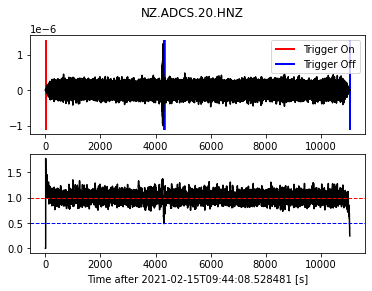

Processing ADCS trace for channel HNZ of trace 1
Filter ADCS with bandpass
Apply recursive sta-lta on ADCS
Trigger-Plot of recursive_sta_lta ADCS


/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/signal/trigger.py:562: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.draw()
/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


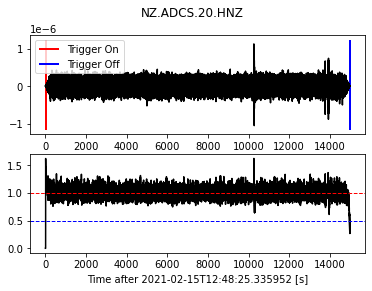

Processing ADCS trace for channel HNZ of trace 2
Filter ADCS with bandpass
Apply recursive sta-lta on ADCS
Trigger-Plot of recursive_sta_lta ADCS


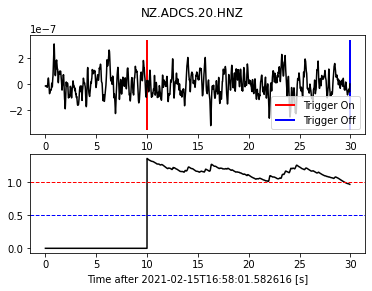

Processing ADCS trace for channel HNZ of trace 3
Filter ADCS with bandpass
Apply recursive sta-lta on ADCS
Trigger-Plot of recursive_sta_lta ADCS


/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/signal/trigger.py:562: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.draw()
/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


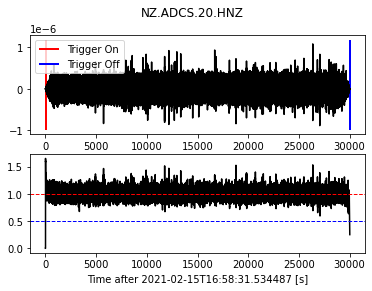

Processing ADCS trace for channel HNZ of trace 4
Filter ADCS with bandpass
Apply recursive sta-lta on ADCS
Trigger-Plot of recursive_sta_lta ADCS


/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/signal/trigger.py:562: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.draw()
/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


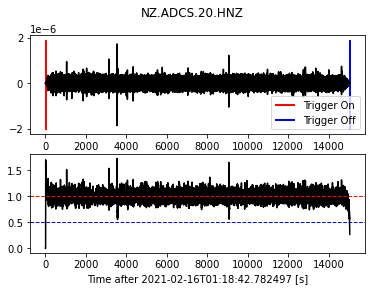

Processing ADCS trace for channel HNZ of trace 5
Filter ADCS with bandpass
Apply recursive sta-lta on ADCS
Trigger-Plot of recursive_sta_lta ADCS


/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/signal/trigger.py:562: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.draw()
/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


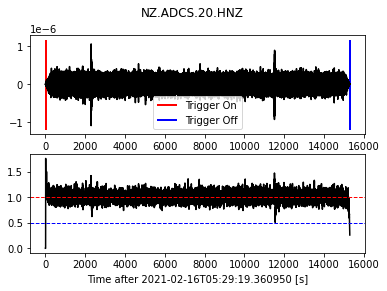

In [2]:
from obspy.signal.trigger import classic_sta_lta, recursive_sta_lta, plot_trigger
from obspy.geodetics import inside_geobounds
from obspy import UTCDateTime, core

''' Set trace window '''
tStart = UTCDateTime.now()-518400 #6 days ago = 60s x 60m x 24h
#tEnd = UTCDateTime.now()-432000   #1 day in the future = 60s x 60m x 24h
tEnd = tStart + (60*60*24)
''' Set filter frequency extremes '''
FilterHighPass = 25.0
FilterLowPass = 0.1
FilterType = 'bandpass'

#cls_st = stations.station_data()
#__client = cls_st.get_client()

for st_code, st_type, st_lat, st_lon in lst_val_st:
    print('Getting %s stream' % st_code)
    try:
        stream = cls_st.get_station_waveform(client=__client,station_code=st_code,StartTime=tStart,EndTime=tEnd)
#        trace.plot()
        if stream.count() > 0 and isinstance(stream, core.stream.Stream):
            print('Remove response from %s stream with %d traces' % (stream[0].stats.station, stream.count()))
            stream.remove_response(output='DISP')
        else:
            raise ValueError('%s has no traces!' % stream[0].stats.station)
        for idx_trace, trace in enumerate(stream.select(component='Z')):
            print('\rProcessing %s trace for channel %s of trace %d' % (trace.stats.station, trace.stats.channel, idx_trace))
##            trace_Z = stream.select(component="Z")[idx_trace]
##            print('\rIntegrate Z component of %s with spline'  % (trace.stats.station))
##            trace_Z.integrate(method='spline')
            ''' Apply the downsampling/decimation to compress the traces if necessary '''
#            print('\rDecemate trace of %s with factor 4'  % (trace.stats.station))
#            trace.decimate(factor=4, no_filter=False, strict_length=False)
            print('\rFilter %s with %s'  % (trace.stats.station,FilterType))
            trace.filter(type=FilterType, freqmin=FilterLowPass, freqmax=FilterHighPass,
                          corners=4, zerophase=True)
#d            item_tr.filter('lowpass', freq=0.4*item_tr.stats.sampling_rate / 4.0)
            sample_rate = trace.stats.sampling_rate
            print('\rApply recursive sta-lta on %s'  % (trace.stats.station))
            cft = recursive_sta_lta(trace.data, int(5 * sample_rate), int(10 * sample_rate))
            print('\rTrigger-Plot of recursive_sta_lta %s'  % (trace.stats.station))
            plot_trigger(trace, cft, 1.0, 0.5)
        break
    except Exception as err:
        if type(err).__name__ == 'FDSNNoDataException':
            print('%s: %s: %s' % (type(err).__name__,st_code, err))
            pass
        else:
            print('%s: %s: %s' % (type(err).__name__,st_code, err))
            break

[ObsPy trigger-picker](https://docs.obspy.org/tutorial/code_snippets/trigger_tutorial.html) offers a multitude of algorithms and functions to apply common EQ picks such as Classic Short Time Average through Long Time Average (STA/LTA).

Component[0] with trace stats 
               network: NZ
               station: KIKS
              location: 20
               channel: HN1
             starttime: 2021-02-04T00:04:16.080000Z
               endtime: 2021-02-05T00:00:01.475000Z
         sampling_rate: 200.0
                 delta: 0.005
                  npts: 17229080
                 calib: 1.0
_fdsnws_dataselect_url: http://service.geonet.org.nz/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'D', 'number_of_records': 43186, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 65353216})
            processing: ['ObsPy 1.2.2: trim(endtime=UTCDateTime(2021, 2, 11, 0, 4, 16, 80000)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2021, 2, 4, 0, 4, 16, 80000))']
              response: Channel Response
	From m/s**2 () to count ()
	Overall Sensitivity: 427336 defined at 1.000 Hz
	6 stages:
		Stage 1: PolesZerosRespons

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/obspy/signal/trigger.py:562: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.draw()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


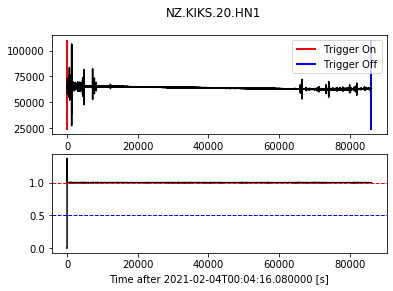

In [5]:
''' DEPRECATE '''
from obspy.signal.trigger import classic_sta_lta, recursive_sta_lta, plot_trigger
#from obspy.signal.trigger import plot_trigger

for idx_tr, item_tr in enumerate(trace):
    print(f'Component[{idx_tr}] with trace stats \n{item_tr.stats}')
    df = item_tr.stats.sampling_rate
#    cft = classic_sta_lta(item_tr.data, int(5 * df), int(10 * df))
#    plot_trigger(item_tr, cft, 1.0, 0.5)
    cft = recursive_sta_lta(item_tr.data, int(5 * df), int(10 * df))
    plot_trigger(item_tr, cft, 1.0, 0.5)
    break
#    for acc in item_tr:
#        print(acc)

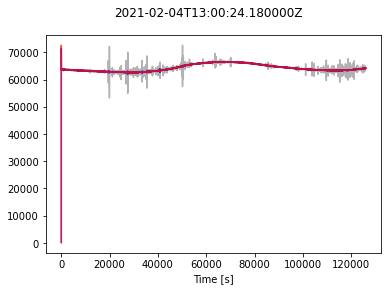

<Figure size 720x720 with 0 Axes>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from obspy.signal.trigger import classic_sta_lta, recursive_sta_lta, plot_trigger

for idx_tr, item_tr in enumerate(trace):

    tr_new = item_tr.copy()
    tr_new.decimate(factor=4, no_filter=False, strict_length=False)
    tr_filt = item_tr.copy()
    tr_filt.filter('lowpass', freq=0.4*item_tr.stats.sampling_rate / 4.0)
    '''
        Now let’s plot the raw and filtered data...
        >>> trace.data = contains all the data in a numpy ndarray 
        >>> trace.stats.sample_rate = the data sampling rate
        >>> trace.stats.npts = the sample count of data
        >>> trace.stats.delta = Sample distance in seconds (default value is 1.0)
    '''
    t = np.arange(0, item_tr.stats.npts / item_tr.stats.sampling_rate, item_tr.stats.delta)
    t_new = np.arange(0, tr_new.stats.npts / tr_new.stats.sampling_rate,tr_new.stats.delta)
    plt.plot(t, item_tr.data, 'k', label='Raw', alpha=0.3)
    plt.plot(t, tr_filt.data, 'b', label='Lowpassed', alpha=0.7)
    plt.plot(t_new, tr_new.data, 'r', label='Lowpassed/Downsampled', alpha=0.7)
    plt.xlabel('Time [s]')
#    plt.xlim(82, 83.5)
    plt.suptitle(item_tr.stats.starttime)
#    plt.legend()
    plt.figure(figsize=(10, 10))
    plt.show()
    break

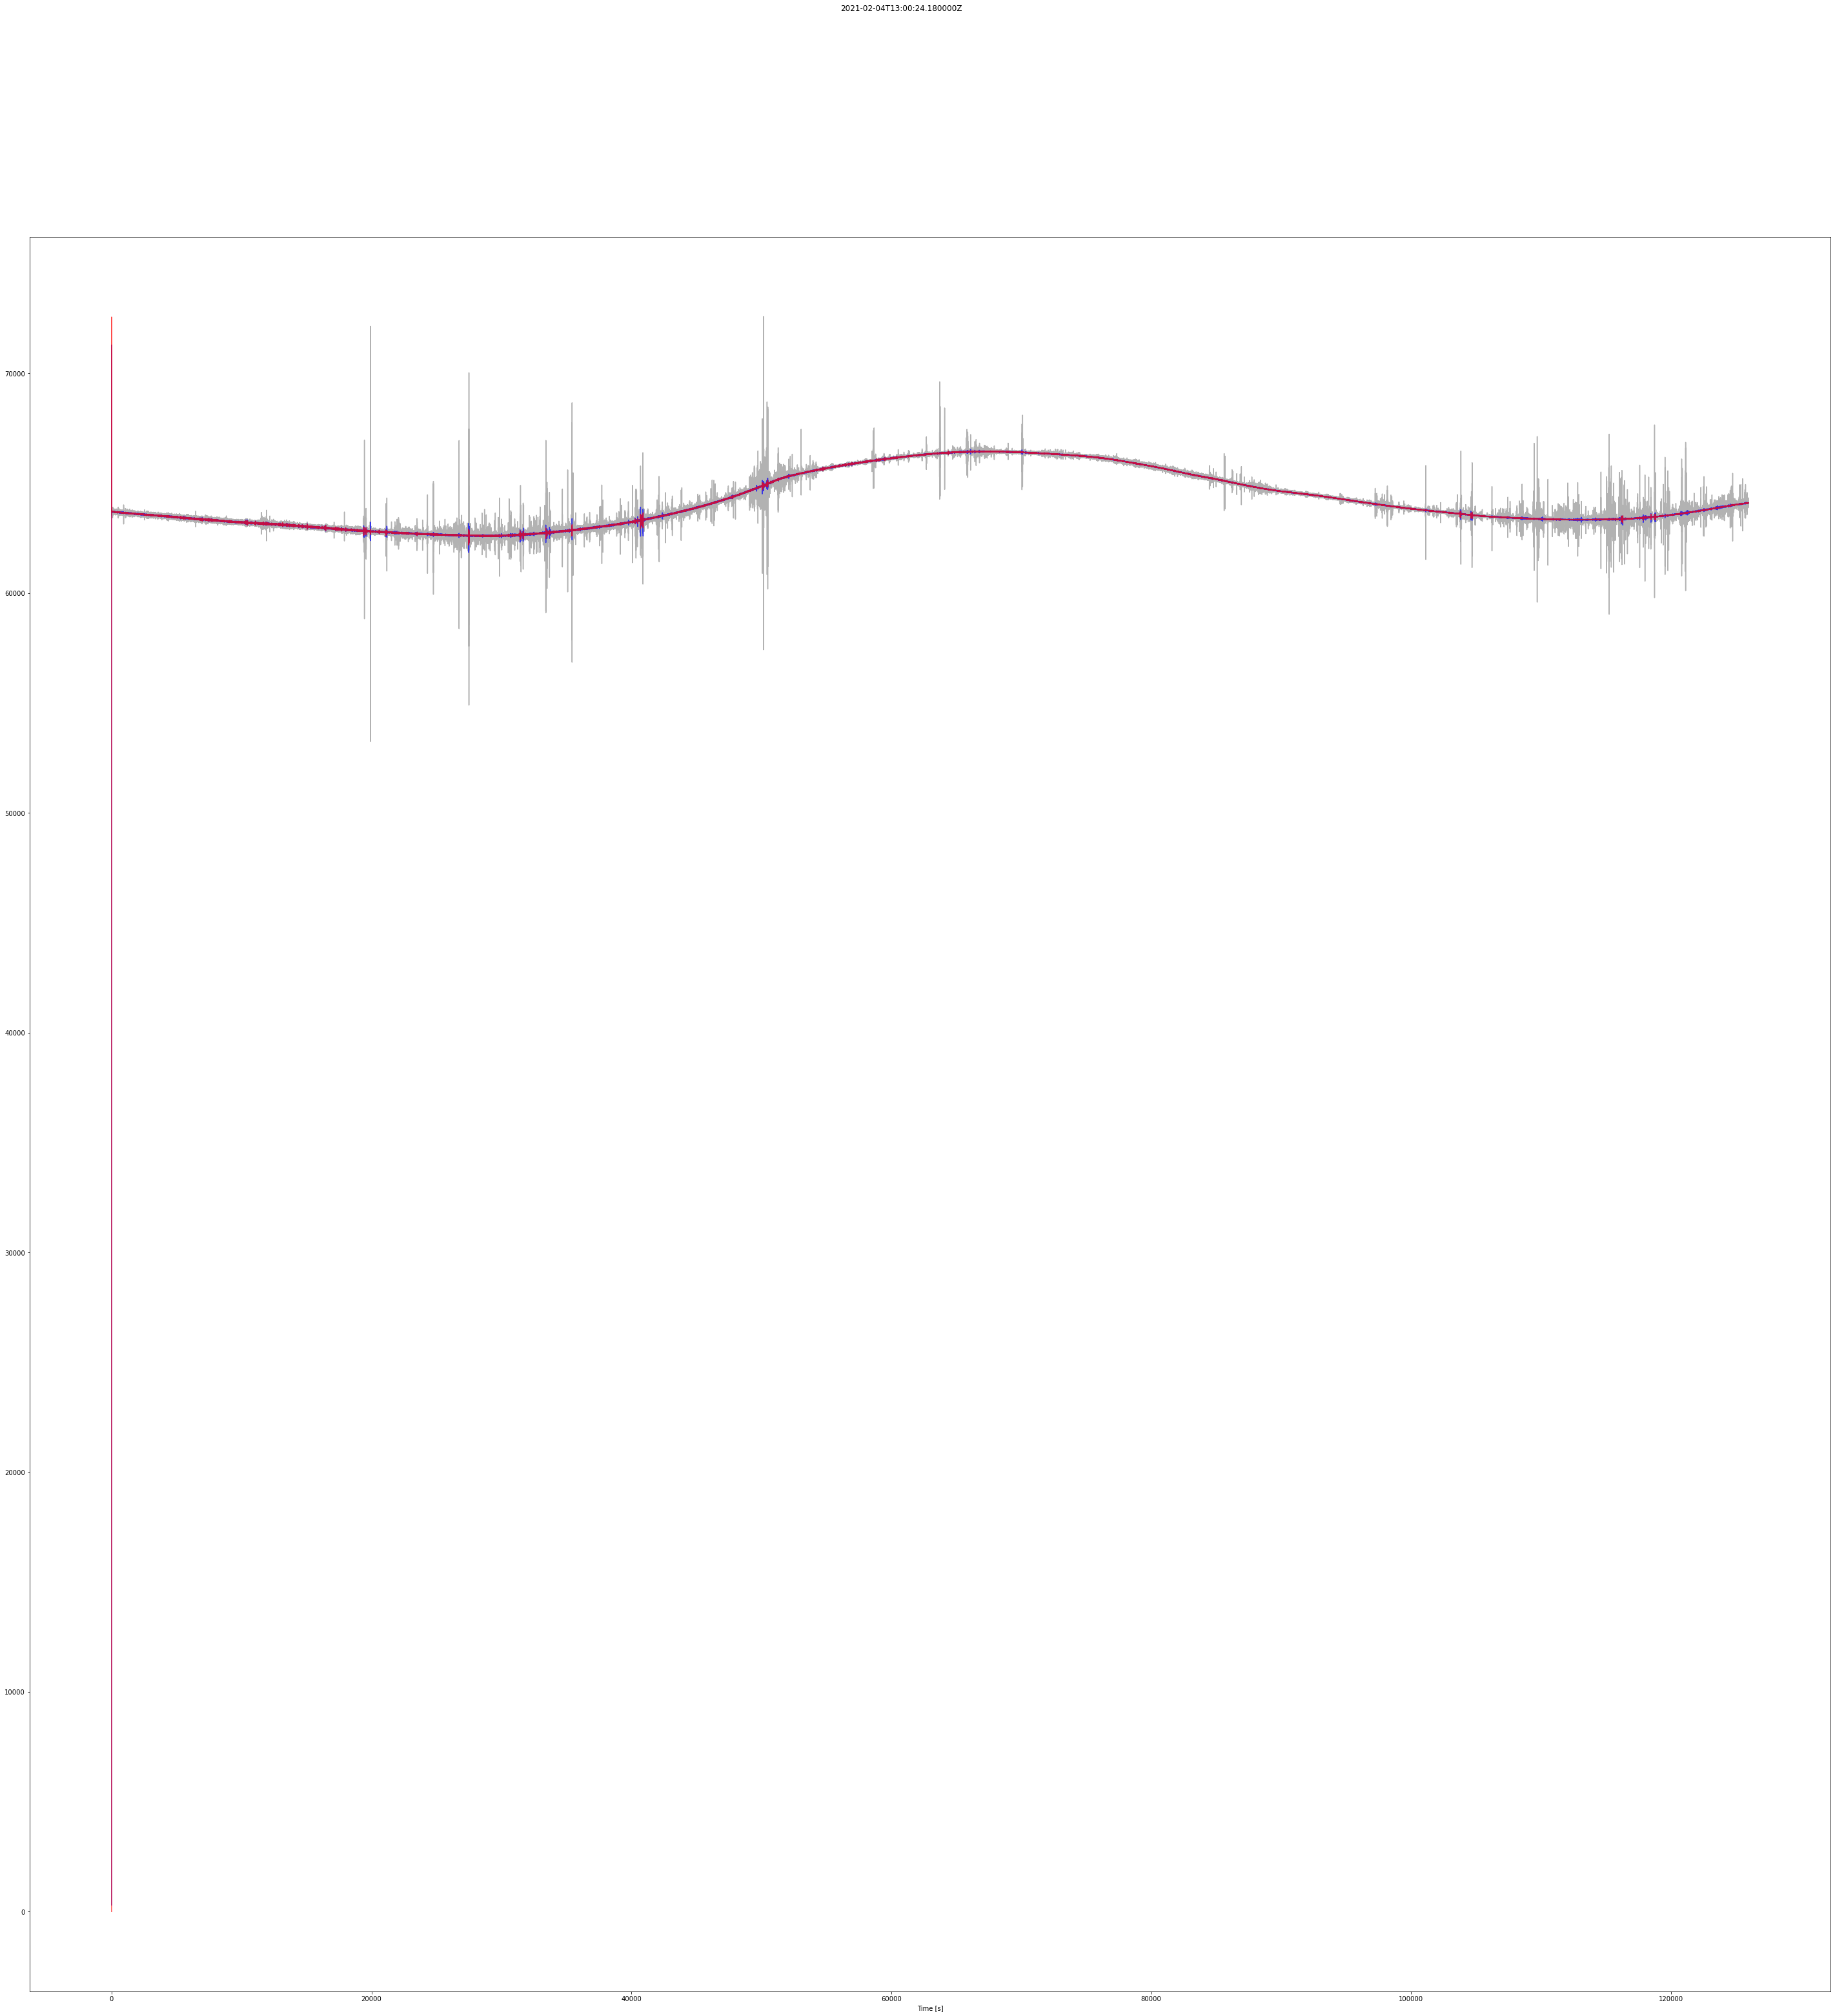

In [7]:
plt.figure(figsize=(50, 20))
plt.plot(t, item_tr.data, 'k', label='Raw', alpha=0.3)
plt.plot(t, tr_filt.data, 'b', label='Lowpassed', alpha=0.7)
plt.plot(t_new, tr_new.data, 'r', label='Lowpassed/Downsampled', alpha=0.7)
plt.xlabel('Time [s]')
#    plt.xlim(82, 83.5)
plt.suptitle(item_tr.stats.starttime)
#    plt.legend()
plt.show()
